In [2]:
import numpy as np
import matplotlib.pyplot as plt
loaded_data = np.load('E_field_data_combined_extended.npz' , allow_pickle=True)
print(loaded_data)
E_data_combined = loaded_data['data']
print(type(E_data_combined))  # To check the type of the loaded data
print(E_data_combined.shape)

<class 'numpy.ndarray'>
(9256, 5)


Normalized Training Set X Shape: (6942, 4) X dtype: float32
Normalized Training Set y Shape: (6942, 101, 181) y dtype: float32
Normalized Validation Set X Shape: (1388, 4) X dtype: float32
Normalized Validation Set y Shape: (1388, 101, 181) y dtype: float32
Normalized Test Set X Shape: (926, 4) X dtype: float32
Normalized Test Set y Shape: (926, 101, 181) y dtype: float32
(18281,)
(101, 181)


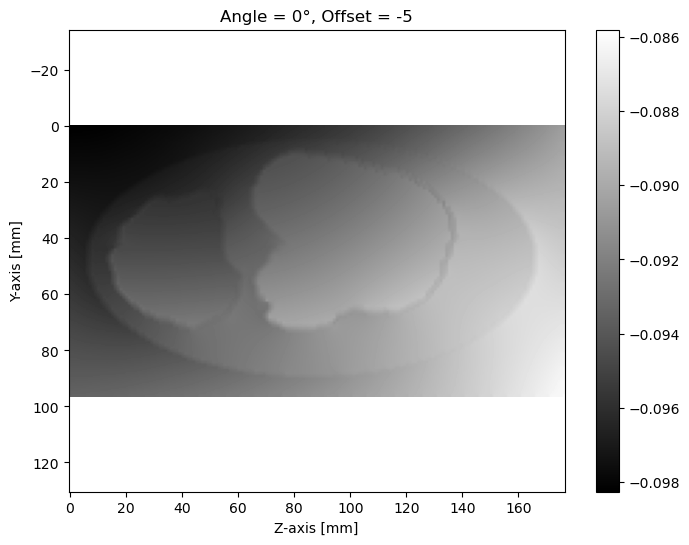

In [5]:
import numpy as np

# Assuming 'data' is loaded and contains the dataset under the key "data"
E_data_combined = loaded_data["data"]

# Split features (first four columns) and matrices (last column)
conditions = E_data_combined[:, :-1].astype(np.float32)  # Convert feature data to float32
matrices = np.array([np.array(matrix, dtype=np.float32) for matrix in E_data_combined[:, -1]])  # Convert matrices

# Normalize conditions
X_normalized = conditions
# Randomly shuffle the data to avoid overfitting
num_samples = X_normalized.shape[0]
indices = np.random.permutation(num_samples)  # Shuffle the indices
X_normalized_shuffled = X_normalized[indices]
y_normalized_shuffled = matrices[indices]

# Calculate indices for training, validation, and test splits
train_size = int(0.75 * num_samples)
val_size = int(0.15 * num_samples)
test_size = num_samples - train_size - val_size  # Ensure all data is used

# Split the shuffled data into training, validation, and test sets
X_train_1, y_train_1 = X_normalized_shuffled[:train_size], y_normalized_shuffled[:train_size]
X_val_1, y_val_1 = X_normalized_shuffled[train_size:train_size + val_size], y_normalized_shuffled[train_size:train_size + val_size]
X_test_1, y_test_1 = X_normalized_shuffled[train_size + val_size:], y_normalized_shuffled[train_size + val_size:]

# Print detailed information about all normalized and split data sets
print("Normalized Training Set X Shape:", X_train_1.shape, "X dtype:", X_train_1.dtype)
print("Normalized Training Set y Shape:", y_train_1.shape, "y dtype:", y_train_1.dtype)
print("Normalized Validation Set X Shape:", X_val_1.shape, "X dtype:", X_val_1.dtype)
print("Normalized Validation Set y Shape:", y_val_1.shape, "y dtype:", y_val_1.dtype)
print("Normalized Test Set X Shape:", X_test_1.shape, "X dtype:", X_test_1.dtype)
print("Normalized Test Set y Shape:", y_test_1.shape, "y dtype:", y_test_1.dtype)


# Check and reshape y_test_1 for visualization
a_check = y_test_1[0].flatten()
print(a_check.shape)
a_check = a_check.reshape(101, 181)
print(a_check.shape)

# Define slicing parameters for plotting
a = slice(2, 179)  # Adjust for Y-axis (selects rows 2 to 178)
b = slice(2, 99)   # Adjust for Z-axis (selects rows 2 to 98)

# Assuming you want to plot only the first image (index 0)
selected_index = 89
angle, offset, direction, _, Ex_data = E_data_combined[selected_index]

plt.figure(figsize=(8, 6))
img = plt.imshow(a_check[b, a], cmap='gray')  # Visualize only the relevant slice of Ex_data

# Set titles and labels
plt.title(f'Angle = {angle}°, Offset = {offset}')
plt.xlabel('Z-axis [mm]')
plt.ylabel('Y-axis [mm]')
plt.axis('equal')  # Maintain equal aspect ratio for better visualization
plt.colorbar(img)  # Add a color bar for scale

# Show the single image
plt.show()


Current layer shape: (None, 128)
Current layer shape: (None, 299)
Current layer shape: (None, 26, 46, 32)
Current layer shape: (None, 52, 92, 16)
Current layer shape: (None, 104, 184, 1)
Current layer shape: (None, 101, 181, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dropout_4 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                160       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               4224      
________________________

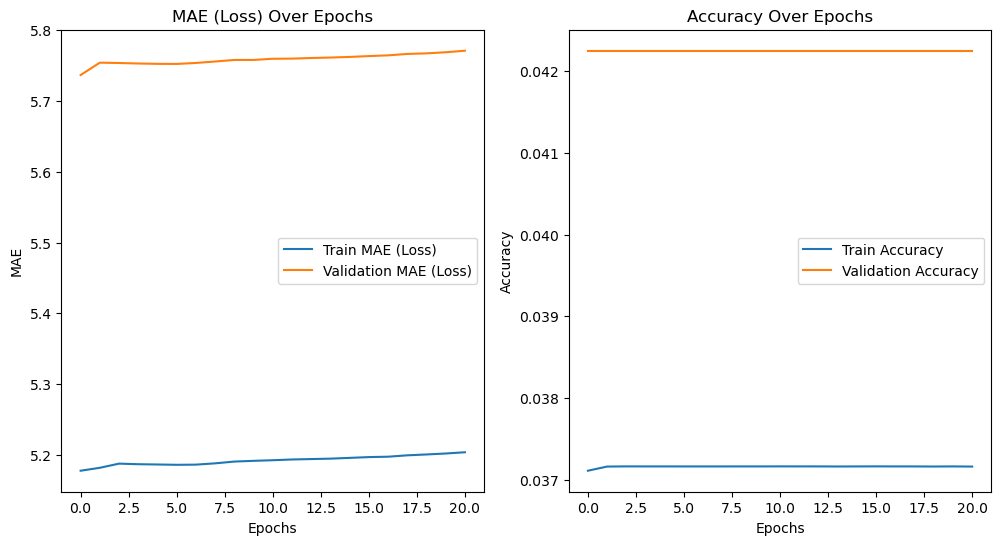

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Reshape, Lambda, Conv2DTranspose, Cropping2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt  # Don't forget to import matplotlib for plotting
from tensorflow.keras.regularizers import l2
def print_shape(x):
    # Function to print the shape of the tensor at each stage
    print('Current layer shape:', x.shape)
    return x


model = Sequential([
    Dense(4, activation='relu', input_shape=(X_train_1.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Lambda(print_shape),
    Dense(13 * 23, activation='relu', kernel_regularizer=l2(0.001)),  # Adjusted output size
    Dropout(0.2),
    Lambda(print_shape),
    Reshape((13, 23, 1)),  # Corrected Reshape syntax
    Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    Lambda(print_shape),
    Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    Lambda(print_shape),
    Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', activation='linear', kernel_regularizer=l2(0.001)),
    Lambda(print_shape),
    Cropping2D(cropping=((1, 2), (1, 2))),  # Adjusted cropping to get desired output size
    Lambda(print_shape),
])

model.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])

# Print model summary to confirm output shape
model.summary()

# Assuming X_train_1, y_train_1, X_val_1, y_val_1 are already defined
# Reshape labels to match the output of the model (101x181)
y_train_reshaped = np.array([y.reshape(101, 181, 1) for y in y_train_1])
y_val_reshaped = np.array([y.reshape(101, 181, 1) for y in y_val_1])

# Define callbacks for training
checkpoint = ModelCheckpoint('best_model_upsampling_update_1.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    X_train_1, y_train_reshaped,
    validation_data=(X_val_1, y_val_reshaped),
    epochs=100, batch_size=32, verbose=1,
    callbacks=[checkpoint, early_stopping]
)

# Function to plot training history
# Function to plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Plot for Loss (MAE)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train MAE (Loss)')
    plt.plot(history.history['val_loss'], label='Validation MAE (Loss)')
    plt.title('MAE (Loss) Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    # Plot for Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plotting the training history
plot_history(history)


In [7]:
# Predict using the trained model on the test set
from tensorflow.keras.models import load_model
# Calculate the mean squared error on the test set
from sklearn.metrics import mean_absolute_error, r2_score
# Load the model
model = load_model('best_model_upsampling_update_1.h5')

print(y_test_1.shape)
y_pred_best_model = model.predict(X_test_1)
# Reshape y_test for comparison
y_test_flat = np.array([y.reshape(101, 181, 1) for y in y_test_1])
print(y_test_flat.shape)
print(y_pred_best_model.shape)

y_test_reshaped = y_test_flat.reshape(y_test_flat.shape[0], -1)
y_pred_reshaped = y_pred_best_model.reshape(y_pred_best_model.shape[0], -1)

# Calculate the mean squared error on the test set
test_mae = mean_absolute_error(y_test_reshaped, y_pred_reshaped)
print("Test MAE:", test_mae)

# Calculate R-squared (optional)
test_r2 = r2_score(y_test_reshaped, y_pred_reshaped)
print("Test R^2 Score:", test_r2)

# Predict on some test samples and compare to the actual values from y_train
for i in range(5):  # Check the first 5 predictions
    print(f"Sample {i} Prediction vs Actual:")
    print("Predicted:", y_pred_best_model[i][:10])  # Print first 10 values of the predicted output
    print("Actual:", y_test_flat[i][:10])  # Print first 10 values of the actual output

Current layer shape: (None, 128)
Current layer shape: (None, 299)
Current layer shape: (None, 26, 46, 32)
Current layer shape: (None, 52, 92, 16)
Current layer shape: (None, 104, 184, 1)
Current layer shape: (None, 101, 181, 1)
(926, 101, 181)
Current layer shape: (None, 128)
Current layer shape: (None, 299)
Current layer shape: (None, 26, 46, 32)
Current layer shape: (None, 52, 92, 16)
Current layer shape: (None, 104, 184, 1)
Current layer shape: (None, 101, 181, 1)
(926, 101, 181, 1)
(926, 101, 181, 1)
Test MAE: 0.18367076
Test R^2 Score: -0.05919848209722817
Sample 0 Prediction vs Actual:
Predicted: [[[-0.02591093]
  [-0.00890846]
  [-0.00715333]
  ...
  [ 0.00108034]
  [-0.0575291 ]
  [-0.07655827]]

 [[-0.02541348]
  [ 0.00269161]
  [ 0.00868643]
  ...
  [ 0.04625247]
  [ 0.08287626]
  [-0.01463808]]

 [[-0.01404076]
  [-0.0220614 ]
  [-0.01505492]
  ...
  [-0.02493026]
  [-0.0197275 ]
  [-0.00266444]]

 ...

 [[-0.03279878]
  [ 0.01360933]
  [ 0.02795384]
  ...
  [ 0.00113792]
  

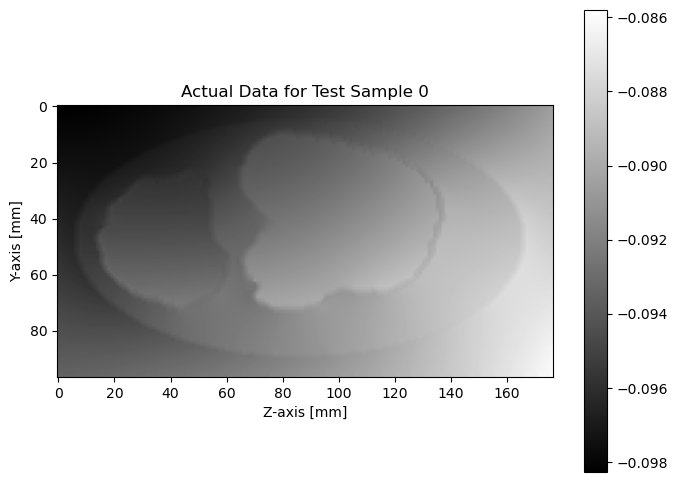

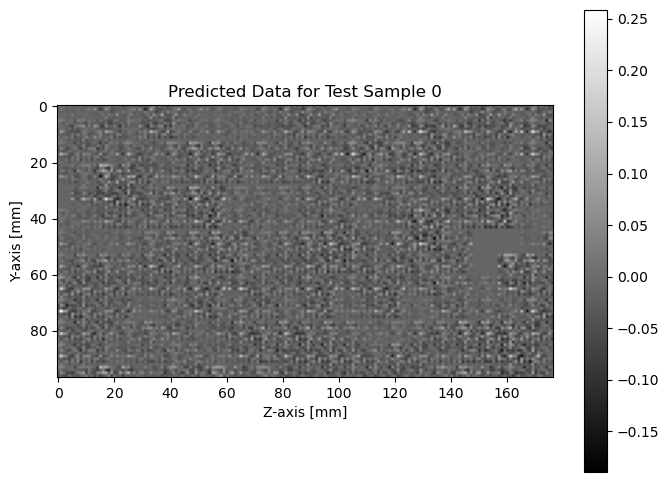

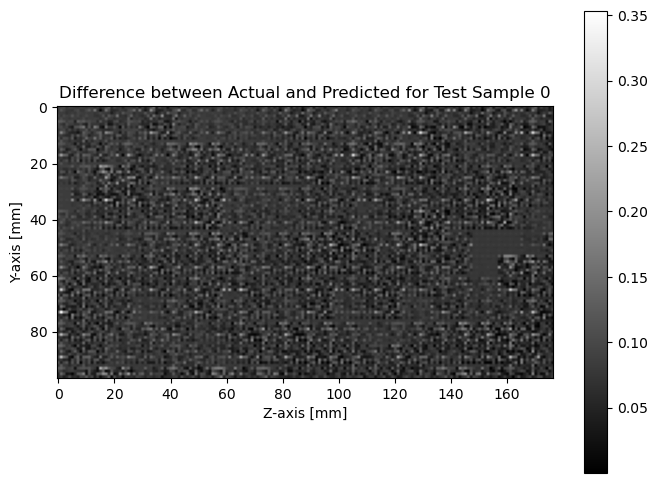

Sample 0 Prediction vs Actual (Flattened):
Predicted (First 10 values): [-0.02591093 -0.00890846 -0.00715333 -0.01997543 -0.02736956  0.00126925
 -0.01742186 -0.01633951 -0.01265839 -0.02462402]
Actual (First 10 values): [-0.09839241 -0.09835688 -0.09835244 -0.09833912 -0.09835688 -0.09833912
 -0.09833912 -0.09833912 -0.09833024 -0.09832136]




: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape y_test and y_pred for comparison
y_test_flat = np.array([y.reshape(-1) for y in y_test_1])
y_pred_flat = np.array([y.reshape(-1) for y in y_pred_best_model])
indices_to_plot = range(1)

# Define slicing parameters for plotting (same as before)
a = slice(2, 179)  # Y-axis (rows)
b = slice(2, 99)   # Z-axis (rows)

for selected_index in indices_to_plot:
    y_test_selected = y_test_flat[selected_index].reshape(101, 181)
    y_pred_selected = y_pred_flat[selected_index].reshape(101, 181)
    
    # Plot actual data
    plt.figure(figsize=(8, 6))
    img_actual = plt.imshow(y_test_selected[b, a], cmap='gray')  # Plot actual data slice
    plt.title(f'Actual Data for Test Sample {selected_index}')
    plt.xlabel('Z-axis [mm]')
    plt.ylabel('Y-axis [mm]')
    plt.colorbar(img_actual)  # Add a color bar for scale
    plt.show()

    # Plot predicted data
    plt.figure(figsize=(8, 6))
    img_pred = plt.imshow(y_pred_selected[b, a], cmap='gray')  # Plot predicted data slice
    plt.title(f'Predicted Data for Test Sample {selected_index}')
    plt.xlabel('Z-axis [mm]')
    plt.ylabel('Y-axis [mm]')
    plt.colorbar(img_pred)  # Add a color bar for scale
    plt.show()

    # Plot difference between actual and predicted
    plt.figure(figsize=(8, 6))
    img_diff = plt.imshow(np.abs(y_test_selected[b, a] - y_pred_selected[b, a]), cmap='gray')  # Plot difference
    plt.title(f'Difference between Actual and Predicted for Test Sample {selected_index}')
    plt.xlabel('Z-axis [mm]')
    plt.ylabel('Y-axis [mm]')
    plt.colorbar(img_diff)  # Add a color bar for scale
    plt.show()

    # Print the actual vs predicted values (flattened for comparison)
    print(f"Sample {selected_index} Prediction vs Actual (Flattened):")
    print("Predicted (First 10 values):", y_pred_flat[selected_index][:10])
    print("Actual (First 10 values):", y_test_flat[selected_index][:10])
    print("\n")
